In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00

In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) Y


In [3]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load your own dataset from CSV files
train_csv_file_path = "/content/train_dataset.csv"  # Replace with the path to your train CSV file
validation_csv_file_path = "/content/validation_dataset.csv"  # Replace with the path to your validation CSV file
test_csv_file_path = "/content/test_dataset.csv"  # Replace with the path to your test CSV file

# Read the CSV files into Pandas DataFrames
train_dataframe = pd.read_csv(train_csv_file_path)
validation_dataframe = pd.read_csv(validation_csv_file_path)
test_dataframe = pd.read_csv(test_csv_file_path)

# Convert the Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_dataframe)
validation_dataset = Dataset.from_pandas(validation_dataframe)
test_dataset = Dataset.from_pandas(test_dataframe)

# Create a DatasetDict in the desired format
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

# Print the DatasetDict to verify
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['Discipline', 'Question', 'Reason you think it is faulty', 'Which top LLM you tried', 'Response by a top LLM', 'Response for tuning'],
        num_rows: 40
    })
    validation: Dataset({
        features: ['Discipline', 'Question', 'Reason you think it is faulty', 'Which top LLM you tried', 'Response by a top LLM', 'Response for tuning'],
        num_rows: 10
    })
    test: Dataset({
        features: ['Discipline', 'Question', 'Reason you think it is faulty', 'Which top LLM you tried', 'Response by a top LLM', 'Response for tuning'],
        num_rows: 11
    })
})


In [7]:
print(f"Number of rows in initial train dataset: {len(dataset_dict['train'])}")


Number of rows in initial train dataset: 40


In [8]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )

## Load the model here

In [9]:
model_name='microsoft/phi-2'
device_map = {"": 0}
original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      device_map=device_map,
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Tokenization
Now, let’s configure the tokenizer, incorporating left-padding to optimize memory usage during training.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

We will evaluate the base model that we loaded above using a few sample inputs.

In [11]:
%%time
from transformers import set_seed
seed = 42
set_seed(seed)

index = 6

question = dataset_dict['test'][index]['Question']
response =dataset_dict['test'][index]['Response for tuning']

# print(question, response)

formatted_prompt = (
  f"{question}\n"
)
# res = gen(original_model,formatted_prompt,100,)


# Tokenize the input prompt
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(original_model.device)
res = original_model.generate(
    inputs["input_ids"],  # Input IDs from the tokenizer
    # max_length=100,       # Define the maximum length of the generated text
    max_new_tokens=200,
    # num_return_sequences=1,  # Number of generated sequences
    temperature=0.7,
)

output = tokenizer.decode(res[0], skip_special_tokens=True)

print(f'MODEL GENERATION - ZERO SHOT:\n{output}')


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


MODEL GENERATION - ZERO SHOT:
In an experiment, a pendulum swings to a maximum height that is 5 cm lower than its starting point. Calculate the potential energy change if the mass of the bob is 1 kg

Solution:
The potential energy of a pendulum is given by the formula:

PE = mgh

where m is the mass of the bob, g is the acceleration due to gravity, and h is the height of the bob above its lowest point.

The maximum height of the pendulum is the distance from the lowest point to the highest point, which is equal to the length of the string times the sine of the angle of displacement. The starting point of the pendulum is the lowest point, so the maximum height is equal to the length of the string times the sine of the angle of displacement minus 5 cm.

The angle of displacement is the angle between the string and the vertical direction, which is equal to the angle of the pendulum at its highest point. The angle of the pendulum at its highest point is 90 degrees, so the angle of displace

In [12]:
def create_prompt_formats(sample):

    INTRO_BLURB = "Below is a science question that is asked to an LLM. Give a response to the question."
    INSTRUCTION_KEY = "Answer the following Question\n"
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    # print("Sample",sample)


    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['Question']}" if sample["Question"] else None
    response = f"{RESPONSE_KEY}\n{sample['Response for tuning']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [13]:
formatted_dataset = dataset_dict['train'].map(create_prompt_formats)
print("First sample after formatting:", formatted_dataset[0])

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

First sample after formatting: {'Discipline': 'Gravity', 'Question': 'If you threw a baseball in space and missed, how long until it comes back to you?', 'Reason you think it is faulty': 'You need to throw it at escape velocity for the ball to reach space.', 'Which top LLM you tried': 'GPT-3', 'Response by a top LLM': " In the vacuum of space without any atmospheric resistance or gravity, an object like a baseball would continue moving at its initial velocity forever. Since there's no air for friction or Earth's gravitational pull to slow it down, if you miss catching your throw in space, that ball will be lost and never return.", 'Response for tuning': " The given question contains an assumption that might not be accurate for understanding your query properly. In this scenario, we are considering space as vacuum with no air resistance or other factors affecting motion like gravity (since baseballs don't travel at significant fractions of light speed).\n\nHowever, if you miss the ball 

In [14]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
        padding="max_length",  # Ensure padding for consistent input size
        # return_tensors="pt"
    )

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)
    print(f"Number of rows after formating: {len(dataset)}")

    # print("Printing dataset to see if there is text", dataset[0])

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    # print("Columns: ",dataset.column_names)

    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['Question', 'Response for tuning']
    )
    print(f"Number of rows in train dataset after tokenizing: {len(dataset)}")
    # print("Printing dataset to see if there is input_ids", dataset[0])
    # Filter out samples that have input_ids exceeding max_length
    print("Max length", max_length)
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) <= max_length)
    print(f"Number of rows in train dataset after fitlering: {len(dataset)}")

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [15]:
max_length = get_max_length(original_model)
print(max_length)

Found max lenth: 2048
2048


In [16]:
tokenized_dataset = formatted_dataset.map(partial(preprocess_batch, tokenizer=tokenizer, max_length=max_length))
print("First sample after tokenization:", tokenized_dataset[0])
print(f"Number of rows in train dataset: {len(tokenized_dataset)}")


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

First sample after tokenization: {'Discipline': 'Gravity', 'Question': 'If you threw a baseball in space and missed, how long until it comes back to you?', 'Reason you think it is faulty': 'You need to throw it at escape velocity for the ball to reach space.', 'Which top LLM you tried': 'GPT-3', 'Response by a top LLM': " In the vacuum of space without any atmospheric resistance or gravity, an object like a baseball would continue moving at its initial velocity forever. Since there's no air for friction or Earth's gravitational pull to slow it down, if you miss catching your throw in space, that ball will be lost and never return.", 'Response for tuning': " The given question contains an assumption that might not be accurate for understanding your query properly. In this scenario, we are considering space as vacuum with no air resistance or other factors affecting motion like gravity (since baseballs don't travel at significant fractions of light speed).\n\nHowever, if you miss the bal

In [17]:
for sample in tokenized_dataset:
    print(len(sample["input_ids"]))  # Print the length of input_ids for each sample

2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048
2048


In [18]:
## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset_dict['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset_dict['validation'])

Found max lenth: 2048
2048
Preprocessing dataset...


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Number of rows after formating: 40


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Number of rows in train dataset after tokenizing: 40
Max length 2048


Filter:   0%|          | 0/40 [00:00<?, ? examples/s]

Number of rows in train dataset after fitlering: 40
Preprocessing dataset...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Number of rows after formating: 10


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Number of rows in train dataset after tokenizing: 10
Max length 2048


Filter:   0%|          | 0/10 [00:00<?, ? examples/s]

Number of rows in train dataset after fitlering: 10


In [19]:
print(train_dataset[0])

{'Discipline': 'Thermodynamics', 'Reason you think it is faulty': 'This scenario suggests a violation of the second law of thermodynamics, as it implies the creation of energy, which is impossible. Entropy should increase, but the energy values suggest a perpetual motion machine of the second kind.', 'Which top LLM you tried': 'GPT-4', 'Response by a top LLM': " To calculate the change in entropy (ΔS) for a reversible isothermal process like this one, we can use the formula:\n\nΔS = Q/T\nwhere:\n- ΔS is the change in entropy, positive if it increases and negative otherwise.\n- Q is the heat transferred during the process (in Joules). In our case, there are two transfers of heat involved - one from inside to outside (-10,000 J) and another from outside to inside (+15,000 J), so net Q = 15,000 - 10,000 = 5,00\n- T is the temperature at which the process occurs (in Kelvin). Since no specific temperature was given in your question and it's assumed that heat transfer happens at constant tem

## Preparing the model for QLoRA
Here, the model is prepared for QLoRA training using the `prepare_model_for_kbit_training()` function. This function initializes the model for QLoRA by setting up the necessary configurations.

In [20]:
# 2 - Using the prepare_model_for_kbit_training method from PEFT
# Preparing the Model for QLoRA
from peft import prepare_model_for_kbit_training
original_model = prepare_model_for_kbit_training(original_model)

## Setup PEFT for Fine-Tuning
Let us now define the LoRA config for Fine-tuning the base model

In [21]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

peft_model = get_peft_model(original_model, config)

In [22]:
def print_number_of_trainable_model_parameters(model):
    """
    Print the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params}")
    print(f"Total parameters: {total_params}")
    print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")


In [23]:
print(print_number_of_trainable_model_parameters(peft_model))

Trainable parameters: 20971520
Total parameters: 1542364160
Percentage of trainable parameters: 1.36%
None


## Train PEFT Adapter
Define training arguments and create Trainer instance

In [26]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'
import transformers

peft_training_args = TrainingArguments(
    output_dir = output_dir,
    warmup_steps=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    max_steps=30,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=25,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=25,
    evaluation_strategy="steps",
    eval_steps=25,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    overwrite_output_dir = 'True',
    group_by_length=True,
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Here, we have used 1000 training steps. It seems to be good enough for our custom dataset. We need to try out different numbers before finalizing with training steps. Also, the hyperparameters used above might vary depending on the dataset/model we are trying to fine-tune. This is just to show the capability of fine-tuning.

Let’s start the training now. Training the model will take some time depending upon the hyperparameters used in TrainingArguments.

In [27]:
peft_trainer.train()

Step,Training Loss,Validation Loss
25,1.850700,1.433579


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=30, training_loss=1.7928450266520182, metrics={'train_runtime': 442.9893, 'train_samples_per_second': 0.135, 'train_steps_per_second': 0.068, 'total_flos': 1968230419660800.0, 'train_loss': 1.7928450266520182, 'epoch': 1.5})

Once the model is trained successfully, we can use it for inference. Let’s now prepare the inference model by adding an adapter to the original Phi-2 model. Here, we are setting is_trainable=False because the plan is only to perform inference with this PEFT model.


In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [29]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [30]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/peft-dialogue-summary-training-1733514237/checkpoint-30",torch_dtype=torch.float16,is_trainable=False)

## Evaluate the Model Qualitatively (Human Evaluation)
Now, let’s perform inference using the same input but with the PEFT model, as we did previously in step 7 with the original model.



In [31]:
%%time
from transformers import set_seed
set_seed(seed)

index = 6
question = dataset_dict['test'][index]['Question']
response =dataset_dict['test'][index]['Response for tuning']

formatted_prompt = (
  f"{question}\n"
)
# res = gen(original_model,formatted_prompt,100,)


# Tokenize the input prompt
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(original_model.device)
res = original_model.generate(
    inputs["input_ids"],  # Input IDs from the tokenizer
    # max_length=100,       # Define the maximum length of the generated text
    max_new_tokens=200,
    # num_return_sequences=1,  # Number of generated sequences
    temperature=0.7,      # Control creativity (lower = more focused, higher = more random)
)


output = tokenizer.decode(res[0], skip_special_tokens=True)

print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


MODEL GENERATION - ZERO SHOT:
In an experiment, a pendulum swings to a maximum height that is 5 cm lower than its starting point. Calculate the potential energy change if the mass of the bob is 1 kg

Answer: To calculate the potential energy change, we need to use the formula for gravitational potential energy (PE) which is given by:

PE = m * g * h

where m is the mass of the object, g is the acceleration due to gravity (approximately 9.8 m/s^2), and h is the height above a reference point.

In this case, the maximum height is 5 cm lower than the starting point, so we can calculate the starting height as follows:

Starting height = Starting point - 5 cm = 0 cm - 5 cm = -5 cm

Now, we can calculate the potential energy change:

PE = 1 kg * 9.8 m/s^2 * (-5 cm)

Since the height is negative, we need to convert it to meters:

PE = 1 kg * 9.8 m/s^2 * (-0.05 m)

PE = -0
CPU times: user 28.8 s, sys: 131 ms, total: 28.9 s
Wall time: 29.2 s


## Evaluate the Model Quantitatively (with ROUGE Metric)




In [32]:
original_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
import pandas as pd

questions = dataset_dict['test'][0:10]['Question']
good_responses = dataset_dict['test'][0:10]['Response for tuning']

original_model_responses = []
instruct_model_responses = []
peft_model_responses = []

for idx, question in enumerate(questions):
    human_baseline_text_output = good_responses[idx]
    prompt = f"{question}"

    inputs = tokenizer(prompt, return_tensors="pt").to(original_model.device)
    res = original_model.generate(
        inputs["input_ids"],  # Input IDs from the tokenizer
        max_new_tokens=200,
        temperature=0.7,      # Control creativity (lower = more focused, higher = more random)
    )
    original_model_text_output = tokenizer.decode(res[0], skip_special_tokens=True)

    peft_model_res = ft_model.generate(
        inputs["input_ids"],  # Input IDs from the tokenizer
        max_new_tokens=200,
        temperature=0.7,      # Control creativity (lower = more focused, higher = more random)
    )
    peft_model_output = tokenizer.decode(peft_model_res[0], skip_special_tokens=True)

    print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('###')

    original_model_responses.append(original_model_text_output)
    peft_model_responses.append(peft_model_text_output)

zipped_responses = list(zip(good_responses, original_model_responses, peft_model_responses))

df = pd.DataFrame(zipped_responses, columns = ['good_responses', 'original_model_responses', 'peft_model_responses'])
df

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_

If you choose an answer to this question at random,
what is the probability that you will be correct?
A) 25%
B) 50%
C) 0%
D) 25%
E) 100%

Solution:
The correct answer is C) 0%.

Explanation:
To determine the probability of being correct when choosing an answer at random, we need to consider the number of correct answers and the total number of possible answers. In this case, there is no correct answer provided, so we cannot calculate the probability.

Follow-up Exercise 1:
What if there were two correct answers instead of one? What would be the probability of being correct when choosing an answer at random?

Solution:
If there were two correct answers instead of one, the probability of being correct when choosing an answer at random would be 50%. This is because there are now two correct options out of a total of two possible answers.

Follow-up Exercise 2:
What if there were three correct answers instead of one? What would be the probability of being correct when choosing an answer at

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Finish the conversation between 2 people talking on the moon
Person 1: "Knock Knock
Person 2: _____ Output: Person 2: Who's there?
Person 1: Output: I'm sorry, I cannot answer that question as I am an AI language model and do not have the ability to communicate with individuals.

Person 2: Oh, I see. Well, I hope you have a great day on the moon!
Person 1: Thank you! Have a wonderful day too!



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A scientist measures the momentum and the location of an particle in a particle accelerator. How smart is the scientist?

Answer:

The scientist is not very smart.

Explanation:

The scientist is not very smart because he is measuring the momentum and location of an electron in a particle accelerator. This is impossible because the Heisenberg Uncertainty Principle states that it is impossible to simultaneously measure both the position and momentum of a particle with absolute precision. Therefore, the scientist's measurements are not accurate or meaningful.

### Question 2:

A physicist is trying to calculate the energy of a photon using the formula E = hf, where E is the energy, h is Planck's constant, and f is the frequency of the photon. However, the physicist accidentally uses the wrong value for Planck's constant, which is 6.

Answer:

The physicist's calculation is incorrect.

Explanation:

The physicist's calculation is incorrect because he used the wrong value for Planck's cons

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Can you calculate the final temperature of a star when it completely stops emitting light and heat? Initial Temperature: 5000 K
Answer: Output: The final temperature of the star is 0 K (absolute zero).

Explanation: When a star stops emitting light and heat, its temperature decreases to absolute zero, which is the lowest possible temperature in the universe.

Follow-up Exercise 1:
What happens to the mass of a star when it stops emitting light and heat?

Solution:
When a star stops emitting light and heat, its mass remains constant. The energy released during the star's lifetime is converted into other forms, such as gravitational potential energy or radiation, but the total mass of the star remains unchanged.

Follow-up Exercise 2:
What happens to the size of a star when it stops emitting light and heat?

Solution:
When a star stops emitting light and heat, its size decreases significantly. The energy released during the star's lifetime is converted into other forms, causing the star 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A human drills a hole straight through the center of the Earth all the way to the other side and jumps in, what would happen?

Answer:

If a human were to drill a hole straight through the center of the Earth all the way to the other side and then jump in, they would likely face several catastrophic consequences. Firstly, the immense pressure and temperature at the Earth's core would cause severe damage to their body, potentially leading to immediate death. Additionally, the sudden change in pressure upon reaching the other side would cause their body to expand rapidly, resulting in severe internal injuries. Furthermore, the Earth's magnetic field, which protects us from harmful solar radiation, would be disrupted upon reaching the other side, exposing the human to potentially lethal levels of radiation. Overall, attempting such a feat would result in immediate and fatal consequences for the human.

Follow-up Exercise 1:

What would happen if the human were to bring a metal object with

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A chemist calculates the pH of a solution by finding the hydrogen ion concentration to be 10 ^−15 M. Calculate the pH of the solution.

Solution:

To calculate the pH of a solution, we need to find the negative logarithm (base 10) of the hydrogen ion concentration. In this case, the hydrogen ion concentration is given as 10^(-15) M.

pH = -log[H+]

pH = -log(10^(-15))

Using the property of logarithms, we can simplify this expression:

pH = -(-15)

pH = 15

Therefore, the pH of the solution is 15.

Follow-up Exercise 1:

What would be the pH of a solution if the hydrogen ion concentration is 10^(-10) M?

Solution:

To calculate the pH of a solution with a hydrogen ion concentration of 10^(-10) M, we can use the same formula as before:

pH = -log[H+


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In an experiment, a pendulum swings to a maximum height that is 5 cm lower than its starting point. Calculate the potential energy change if the mass of the bob is 1 kg and the acceleration due to gravity is 9.8 m/s^2.
## INPUT

##OUTPUT
To calculate the potential energy change, we need to find the initial and final potential energies of the bob. The potential energy of an object at a given height is given by the formula:

PE = m * g * h

where m is the mass, g is the acceleration due to gravity, and h is the height.

The initial potential energy of the bob when it is at its starting point is:

PE_initial = m * g * h_initial

where h_initial is the initial height of the bob. Since the maximum height is 5 cm lower than the starting point, we can write:

h_initial = 0.05 m

Therefore, the initial potential energy is:

PE_initial = 1 kg * 9.8 m/s^2 * 0.05 m =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


How long does a flight flying at 300 miles per hour in a straight line take to cross Las Vegas, NV to Reno, NV?
Answer: The distance between Las Vegas, NV and Reno, NV is approximately 270 miles. Therefore, a flight flying at 300 miles per hour in a straight line would take approximately 0.9 hours or 54 minutes to cross this distance.

Follow-up Question 1: If the flight had to make a detour to avoid a thunderstorm, how long would it take to reach Reno?
Answer: The detour would add an additional 10 miles to the distance, making it 280 miles. At a speed of 300 miles per hour, it would take approximately 0.93 hours or 55 minutes to reach Reno.

Follow-up Question 2: If the flight had to make a stopover in Las Vegas for refueling, how long would it take to reach Reno?
Answer: Assuming the flight takes off and lands in Las Vegas within the same day, it would take approximately 1 hour to refuel and then continue to Reno. Therefore, the total time would be approximately 1 hour


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A physics student is conducting experiments with a simple pendulum and initially measures the time for 20 oscillations as 40 seconds. Due to a calculation error in converting this measurement to the period for a single oscillation, the student erroneously records the period as    T=−2 seconds. Assuming the student continues with this incorrect period value, calculate the length of the pendulum using the formula 𝑇=2𝜋 root(𝐿/𝑔), where    g=9.8m/s2 is the acceleration due to gravity.

Answer 1: The correct period for a simple pendulum is given by T=2𝜋 root(𝐿/𝑔), where T is the period, 𝐿 is the length of the pendulum, and g is the acceleration due to gravity. In this case, the student mistakenly recorded the period as T=−2 seconds, which is not physically possible. Therefore, we cannot use this incorrect value to calculate the length of the pendulum.

Question 2: However, if we assume that the student's measurement was correct and the period is indeed T=−2 seconds, what would be the length

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What is the boiling point of water at a pressure lower than any possible vacuum?

Answer: The boiling point of water at a pressure lower than any possible vacuum is undefined.

Explanation: The boiling point of a liquid is the temperature at which its vapor pressure equals the external pressure. If the external pressure is lower than any possible vacuum, then there is no limit to how low the vapor pressure can go, and therefore no limit to how low the boiling point can be. In other words, there is no such thing as boiling water at a pressure lower than any possible vacuum.

### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required.
### Output: No output required


,good_responses,original_model_responses,peft_model_responses
0,The flaw in this question lies in its assumpt...,If you choose an answer to this question at ra...,If you choose an answer to this question at ra...
1,The flaw in this scenario is that there are n...,Finish the conversation between 2 people talki...,Finish the conversation between 2 people talki...
2,The given question seems to contain a logical...,A scientist measures the momentum and the loca...,A scientist measures the momentum and the loca...
3,The given question contains an inherent flaw ...,Can you calculate the final temperature of a s...,Can you calculate the final temperature of a s...
4,The scenario presented in this question is no...,A human drills a hole straight through the cen...,A human drills a hole straight through the cen...
5,"The calculation for pH is logarithmic, based ...",A chemist calculates the pH of a solution by f...,A chemist calculates the pH of a solution by f...
6,The given problem seems to have a flaw as it ...,"In an experiment, a pendulum swings to a maxim...","In an experiment, a pendulum swings to a maxim..."
7,"To answer this question accurately, I need so...",How long does a flight flying at 300 miles per...,How long does a flight flying at 300 miles per...
8,The flaw in this question lies in the negativ...,A physics student is conducting experiments wi...,A physics student is conducting experiments wi...
9,The given question contains two potential fla...,What is the boiling point of water at a pressu...,What is the boiling point of water at a pressu...


In [34]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_responses,
    references=good_responses[0:len(original_model_responses)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_responses,
    references=good_responses[0:len(peft_model_responses)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

ORIGINAL MODEL:
{'rouge1': 0.3165534929934082, 'rouge2': 0.11653194923122623, 'rougeL': 0.19412291825317876, 'rougeLsum': 0.2664221522799757}
PEFT MODEL:
{'rouge1': 0.38779228348544104, 'rouge2': 0.13509259115632724, 'rougeL': 0.23328597488156166, 'rougeLsum': 0.30391176167244727}
Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 7.12%
rouge2: 1.86%
rougeL: 3.92%
rougeLsum: 3.75%


In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ROUGE scores from both models
original_model_results = {'rouge1': 0.3165534929934082, 'rouge2': 0.11653194923122623, 'rougeL': 0.19412291825317876, 'rougeLsum': 0.2664221522799757}
peft_model_results = {'rouge1': 0.38779228348544104, 'rouge2': 0.13509259115632724, 'rougeL': 0.23328597488156166, 'rougeLsum': 0.30391176167244727}

# Percentage improvements calculated
improvements = {
    'rouge1': 7.12,
    'rouge2': 1.86,
    'rougeL': 3.92,
    'rougeLsum': 3.75
}

# Prepare data for plotting
labels = list(improvements.keys())
original_values = [original_model_results[k] for k in labels]
peft_values = [peft_model_results[k] for k in labels]
improvement_values = [improvements[k] for k in labels]


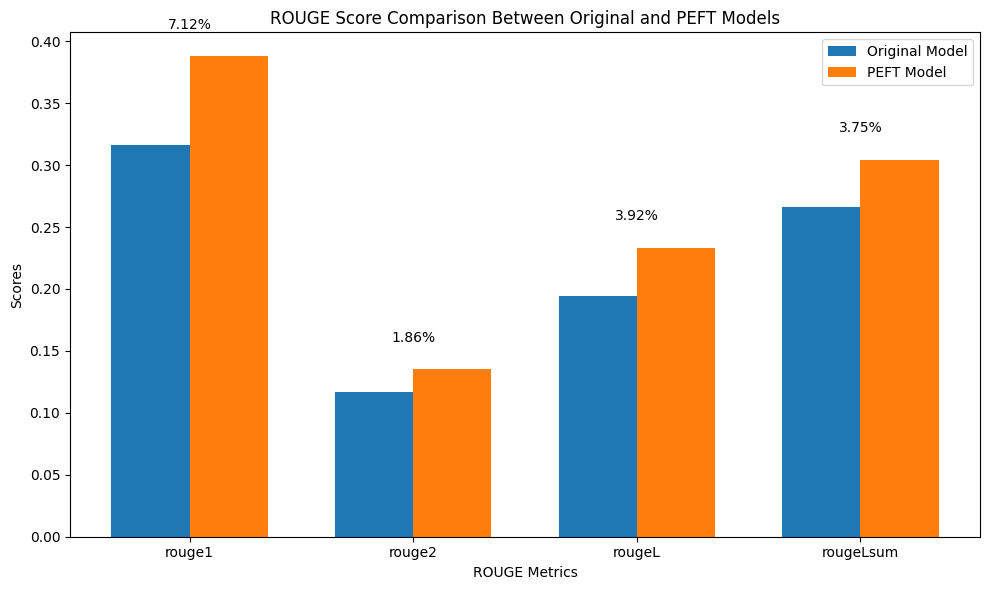

In [42]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_values, width, label='Original Model')
rects2 = ax.bar(x + width/2, peft_values, width, label='PEFT Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Score Comparison Between Original and PEFT Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar, displaying the improvement
for i in range(len(labels)):
    ax.text(i, max(original_values[i], peft_values[i]) + 0.02, f'{improvement_values[i]:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
